# Interactive visual representation of dimentionality reduction and clustering of EQ-5D-5L records and their result on diseases

# Data include records from UK, France and Germany 

  ### -EQ-5D-5L records 
  ### -Sociodemographic features 
  ### -Diagnoses



In [2]:
import savReaderWriter as spss
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.style as style
style.use('seaborn')

import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interactive, Layout, HTML


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from imblearn.over_sampling import SMOTE
import itertools

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")


#import plotly.plotly as py
#import chart_studio as py
#from chart_studio.plotly import plot, iplot
import plotly.express as px
import plotly.graph_objects as go

import plotly.figure_factory as ff
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import parallel_coordinates
palette = sns.color_palette("bright", 10)




In [3]:
raw_data = spss.SavReader('p29_data.sav', returnHeader = True)
raw_data_list = list(raw_data)
df = pd.DataFrame(raw_data_list)
with spss.SavReader('p29_data.sav', ioUtf8 = True) as reader:
    df = pd.DataFrame(reader.all(), columns = [s.decode('CP1252') for s in reader.header])
        
    
#prom= df[[ 'WEIGHT', 'GENDER', 'AGER','AGE','E1', 'E2', 'E3', 'E4', 'E5', 'E6']].copy()
eq5d= df[[ 'WEIGHT', 'GENDER', 'AGE','AGER','E1', 'E2', 'E3', 'E4', 'E5', 'E6']].copy()
eq5d.columns = ['WEIGHT', 'GENDER', 'AGE','AGE GROUP' ,'MOBILITY', 'SELF CARE', 'USUAL ACTIVITY', 'PAIN', 'ANXIETY', 'HEALTH SCALE']


eq= eq5d[['MOBILITY', 'SELF CARE', 'USUAL ACTIVITY', 'PAIN', 'ANXIETY']].copy()
new = eq5d.copy()
new['GENERAL HEALTH'] = eq.sum(axis=1)
#eq5d.head(3)    

In [4]:
dff= df[[ 'WEIGHT', 'GENDER', 'AGE','AGER','OCC', 'HHCMP5', 'MARITAL','EDU3','INC4','E1', 'E2', 'E3', 'E4', 'E5', 'E6','Q12_1', 'Q12_2', 'Q12_3',
       'Q12_4', 'Q12_5', 'Q12_6', 'Q12_7', 'Q12_8', 'Q12_9', 'Q12_10',
       'Q12_11', 'Q12_12', 'Q12_13', 'Q12_14', 'Q12_15', 'Q12_16', 'Q12_17',
       'Q12_18']].copy()




dff.columns = ['WEIGHT', 'GENDER', 'AGE','AGE GROUP' ,
               'OCCUPATION','FAMILY_NUMBER','MARITAL','EDUCATION','INCOME',
               'MOBILITY', 'SELF CARE', 'USUAL ACTIVITY', 'PAIN', 'ANXIETY', 'HEALTH SCALE',
               'Heart Disease', 'High Blood Pressure','Leg Pain(due to poor circulation)','Lung Disease','Diabetes',
               'Kidney Disease', 'Liver Disease', 'Problems cause by stroke', 'Nervous System Disease','Cancer','Depression',
               'Arthritis','Substance abuse(Alcohol or drugs)', 'Somatoform disorder (unexplained medical symptoms)','Personality disorder',
               'Chronic pain disorder','Schizophrenic disorder','None of the following'
               ]

In [5]:
dis = dff[[ 'MOBILITY', 'SELF CARE', 'USUAL ACTIVITY', 'PAIN', 'ANXIETY', 'HEALTH SCALE','Heart Disease', 'High Blood Pressure','Leg Pain(due to poor circulation)','Lung Disease','Diabetes',
               'Kidney Disease', 'Liver Disease', 'Problems cause by stroke', 'Nervous System Disease','Cancer','Depression',
               'Arthritis','Substance abuse(Alcohol or drugs)', 'Somatoform disorder (unexplained medical symptoms)','Personality disorder',
               'Chronic pain disorder','Schizophrenic disorder','None of the following']].copy()

# Dimensionality Reduction

In [6]:
# Some functions to plot just the variables that has significant deviation from global mean
def outside_limit(df, label_col, label, sensitivity):
  feature_list = dfskills.columns[:-1]
  
  plot_list = []
  mean_overall_list = []
  mean_cluster_list = []
  
  for i,varname in enumerate(feature_list):
    
    #     get overall mean for a variable, set lower and upper limit
    mean_overall = df[varname].mean()
    lower_limit = mean_overall - (mean_overall*sensitivity)
    upper_limit = mean_overall + (mean_overall*sensitivity)
    #print('mean and upper', mean_overall,upper_limit,i,varname)

    #     get cluster mean for a variable
    cluster_filter = df[label_col]==label
    pd_cluster = df[cluster_filter]
    mean_cluster = pd_cluster[varname].mean()
    #print('mean cluster', mean_cluster)
    
    #     create filter to display graph with 0.5 deviation from the mean
    #if mean_cluster <= lower_limit or mean_cluster >= upper_limit:
    if  mean_cluster >= upper_limit :
      plot_list.append(varname)
      mean_overall_std = mean_overall/mean_overall
      mean_cluster_std = mean_cluster/mean_overall
      mean_overall_list.append(mean_overall_std)
      mean_cluster_list.append(mean_cluster_std)
   
  mean_df = pd.DataFrame({'feature_list':plot_list,
                         'mean_overall_list':mean_overall_list,
                         'mean_cluster_list':mean_cluster_list})
  mean_df = mean_df.sort_values(by=['mean_cluster_list'], ascending=False)
  
  return mean_df

def plot_barchart_all_unique_features(df, label_col, label, ax, sensitivity):
  
  mean_df = outside_limit(df, label_col, label, sensitivity)
  mean_df_to_plot = mean_df.drop(['mean_overall_list'], axis=1)
  
  if len(mean_df.index) != 0:
    sns.barplot(y='feature_list', x='mean_cluster_list', data=mean_df_to_plot, palette=sns.cubehelix_palette(20, start=.5, rot=-.75, reverse=True), \
                alpha=0.75, dodge=True, ax=ax)

    for i,p in enumerate(ax.patches):
      ax.annotate("{:.02f}".format((p.get_width())), 
                  (1, p.get_y() + p.get_height() / 2.), xycoords=('axes fraction', 'data'),
                  ha='right', va='top', fontsize=10, color='black', rotation=0, 
                  xytext=(0, 0),
                  textcoords='offset pixels')
  
  ax.set_title('Unique Characteristics of Cluster ' + str(label))
  ax.set_xlabel('Standardized Mean')
  ax.axvline(x=1, color='k')

def plot_features_all_cluster(df, label_col, n_clusters, sensitivity):
  n_plot = n_clusters
  fig, ax = plt.subplots(n_plot, 1, figsize=(12, n_plot*6), sharex='col')
  ax= ax.ravel()
  
  label = np.arange(n_clusters)
  for i in label:
    plot_barchart_all_unique_features(df, label_col, label=i, ax=ax[i], sensitivity=sensitivity)
    ax[i].xaxis.set_tick_params(labelbottom=True)
    
  plt.tight_layout()
  #display(fig)

In [7]:



def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''
    
    return (colour[0],colour[1],colour[2],alpha)


def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)   
            
            
            
            
            

def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)              

In [8]:
#scaler = MinMaxScaler(feature_range=(1,5))
scaler = StandardScaler()

scale = new.copy()
#scale[['HEALTH SCALE', 'GENERAL HEALTH','AGE']] = scaler.fit_transform(scale[['HEALTH SCALE', 'GENERAL HEALTH','AGE']])
#scale = scaler.fit_transform(scale)

In [9]:
pca = PCA(n_components=3, whiten=True).fit(scale)
X_pca = pca.transform(scale)

In [10]:
# Create a k-means clustering model
kmeans = KMeans(init='random', n_clusters=5, n_init=10)

# Fit the data to the model
kmeans.fit(X_pca)

# Determine which clusters each data point belongs to:
clusters =  kmeans.predict(X_pca)

In [11]:
#tsne = TSNE(n_components=3, random_state=0)
#tsn = tsne.fit_transform(X_pca)

In [35]:
#np.save('tsne.npy', tsn)

In [36]:
tsn = np.load('tsne.npy')

In [37]:
det = HTML()
color_3 = widgets.Dropdown(
        value='ANXIETY', description='color by ',
        options=dff.columns)
def change(change):
    fi.data[0].marker.color = dff[color_3.value].values

fi = px.scatter(
    tsn, x=2, y=1,
    color=dff.MOBILITY)

color_3.observe(change, names="value")
fi = go.FigureWidget(fi)

sca = fi.data[0]

def hover_fn(trace, points,state):
    ind = points.point_inds[0]
    c = dff.iloc[ind]
    c = c[c > 0].dropna()
    det.value = c.to_frame().to_html()

sca.on_hover(hover_fn) 

widgets.VBox([color_3 ,fi,det]) 

In [13]:
dett = HTML()
color = widgets.Dropdown(
        value='ANXIETY', description='color by ',
        options=dff.columns)
def change(change):
    fii.data[0].marker.color = dff[color.value].values
    
Scene = dict(xaxis = dict(title  = 'COMPONENT 1'),yaxis = dict(title  = 'COMPONENT 2'),zaxis = dict(title  = 'COMPONENT 3'))    
layout = go.Layout(margin=dict(l=0,r=0),scene=Scene, height = 800,width = 800)

trace = go.Scatter3d( x=tsn[:,0], y=tsn[:,1],z=tsn[:,2], mode='markers',marker=dict(color = new.ANXIETY , size= 10, line=dict(color= 'black',width = 10)))
data = [trace]
fii = go.Figure(data = data,layout = layout)

color.observe(change, names="value")
fii = go.FigureWidget(fii)

sca = fii.data[0]

def hover_fn(trace, points,state):
    ind = points.point_inds[0]
    v = dff.iloc[ind]
    v = v[v > 0].dropna()
    dett.value = v.to_frame().to_html()

sca.on_hover(hover_fn) 

widgets.VBox([color,fii,dett])  

# Clustering

In [14]:
details = HTML()


model = KMeans(n_clusters =5, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)   
y_clusters = model.fit_predict(tsn)
labels = model.labels_ 


Scene = dict(xaxis = dict(title  = 'DEPRESSION'),yaxis = dict(title  = 'AGE'),zaxis = dict(title  = 'MOBILITY'))
trace = go.Scatter3d(x=dff.iloc[:, 8], y=dff.iloc[:, 2], z=dff.iloc[:, 4], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
figure = go.FigureWidget(fig)


def cluster(change):
    model = KMeans(n_clusters = no_C.value , init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)   
    y_clusters = model.fit_predict(tsn)
    labels = model.labels_ 
    figure.data[0].marker.color = labels
    c = labels 
    return c

def change(change):
    figure.data[0].x = dff[X.value].values
    figure.data[0].y = dff[Y.value].values 
    figure.data[0].z = dff[Z.value].values
    figure.layout.scene.xaxis.title.text = X.value
    figure.layout.scene.yaxis.title.text = Y.value
    figure.layout.scene.zaxis.title.text = Z.value



no_C = widgets.Dropdown(
    value=5, description='Clusters',
    options=[1,2,3,4,5,6,7,8,9,10,11])



X = widgets.Dropdown(
        value='ANXIETY', description='X',
        options=dff.columns)

Y = widgets.Dropdown(
        options=dff.columns.tolist(), description='Y',
        value='AGE')

Z = widgets.Dropdown(
        options=dff.columns.tolist(), description='Z',
        value='MOBILITY')
    
X.observe(change, names="value")
Y.observe(change, names="value")
Z.observe(change, names="value")
no_C.observe(cluster, names="value")


scatt = figure.data[0]

def hover_fn(trace, points,state):
    ind = points.point_inds[0]
    b = dff.iloc[ind]
    b = b[b > 0].dropna()
    details.value = b.to_frame().to_html()

scatt.on_hover(hover_fn) 
    
wid1 = widgets.VBox([X,Y,Z])
wid2 = widgets.HBox([wid1,no_C])
widgets.VBox([wid2,figure,details])  


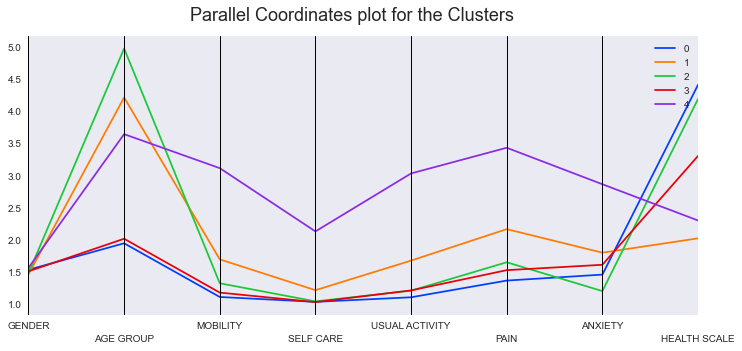

In [15]:
centers = pca.inverse_transform(kmeans.cluster_centers_)
centroids = pd.DataFrame(centers, columns=new.columns)
centroids['cluster'] = centroids.index
centroids = centroids.drop(['AGE','GENERAL HEALTH','WEIGHT'],axis = 1)
centroids['HEALTH SCALE'] = centroids['HEALTH SCALE']/20

display_parallel_coordinates_centroids(centroids, 4)

In [16]:
from kmodes.kprototypes import KPrototypes

In [17]:
X = new.to_numpy()

In [18]:
# Running K-Prototype clustering
#kproto = KPrototypes(n_clusters=5, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2,gamma=.25) 
#clusterss = kproto.fit_predict(X, categorical=[1,3,4,5,6,7,8])

In [19]:
diss = dff[['HEALTH SCALE','Heart Disease', 'High Blood Pressure','Leg Pain(due to poor circulation)','Lung Disease','Diabetes',
               'Kidney Disease', 'Liver Disease', 'Problems cause by stroke', 'Nervous System Disease','Cancer','Depression',
               'Arthritis','Substance abuse(Alcohol or drugs)', 'Somatoform disorder (unexplained medical symptoms)','Personality disorder',
               'Chronic pain disorder','Schizophrenic disorder','None of the following']].copy()

In [33]:
clusterss =[4, 4, 4, 4, 3, 1, 3, 2, 4, 1, 1, 4, 4, 2, 4, 4, 2, 4, 2, 2, 2, 1,
       4, 4, 3, 4, 0, 4, 2, 2, 2, 4, 0, 4, 2, 2, 4, 0, 0, 4, 3, 0, 1, 1,
       1, 3, 4, 2, 1, 3, 2, 3, 2, 1, 2, 3, 0, 0, 4, 4, 0, 1, 0, 4, 3, 0,
       2, 0, 2, 0, 3, 2, 2, 0, 1, 2, 2, 0, 3, 1, 4, 2, 2, 2, 3, 0, 3, 2,
       2, 3, 4, 2, 2, 0, 0, 4, 4, 3, 2, 4, 3, 4, 1, 0, 0, 3, 2, 4, 1, 4,
       2, 2, 2, 1, 0, 2, 3, 2, 2, 1, 1, 0, 1, 0, 2, 2, 2, 1, 4, 2, 2, 2,
       4, 1, 0, 3, 2, 0, 0, 0, 0, 3, 3, 0, 4, 2, 0, 1, 2, 3, 0, 2, 4, 2,
       2, 1, 2, 4, 4, 1, 2, 2, 4, 2, 4, 2, 1, 2, 2, 2, 2, 1, 1, 1, 4, 1,
       2, 4, 4, 4, 4, 2, 0, 4, 4, 2, 4, 0, 1, 3, 2, 4, 2, 4, 0, 2, 2, 4,
       1, 1, 3, 0, 2, 1, 2, 4, 2, 1, 1, 1, 0, 1, 2, 3, 4, 1, 3, 2, 1, 4,
       1, 4, 3, 0, 2, 0, 4, 2, 2, 2, 4, 2, 2, 0, 3, 4, 1, 3, 3, 0, 2, 2,
       4, 2, 4, 1, 3, 4, 1, 2, 2, 2, 1, 4, 2, 4, 2, 2, 4, 4, 0, 1, 0, 0,
       2, 2, 3, 3, 4, 1, 0, 4, 0, 4, 2, 2, 0, 4, 0, 2, 3, 3, 4, 2, 4, 0,
       4, 2, 2, 2, 1, 2, 2, 2, 1, 3, 0, 1, 2, 0, 2, 4, 1, 4, 0, 0, 2, 0,
       0, 2, 4, 0, 4, 0, 1, 0, 3, 2, 0, 1, 1, 2, 4, 2, 2, 4, 4, 1, 3, 2,
       0, 2, 3, 2, 0, 1, 4, 0, 2, 3, 3, 2, 2, 4, 1, 0, 1, 1, 0, 4, 0, 2,
       3, 2, 4, 0, 1, 2, 2, 4, 0, 2, 3, 2, 2, 2, 0, 2, 2, 1, 4, 2, 0, 1,
       4, 4, 2, 4, 2, 4, 2, 2, 2, 3, 1, 3, 1, 4, 2, 2, 4, 0, 4, 1, 2, 3,
       0, 2, 0, 2, 2, 4, 0, 1, 1, 4, 3, 1, 0, 3, 1, 1, 3, 4, 4, 2, 0, 3,
       0, 2, 2, 0, 1, 2, 0, 0, 3, 0, 1, 0, 0, 0, 1, 4, 3, 4, 4, 1, 1, 4,
       2, 1, 4, 3, 4, 0, 1, 4, 1, 0, 2, 4, 4, 4, 4, 0, 4, 1, 0, 1, 4, 3,
       2, 1, 4, 4, 1, 2, 1, 4, 1, 4, 1, 1, 4, 3, 4, 2, 2, 4, 4, 4, 1, 0,
       1, 1, 3, 4, 4, 4, 1, 4, 3, 2, 1, 2, 4, 3, 4, 4, 1, 0, 4, 1, 2, 0,
       3, 4, 2, 3, 1, 4, 4, 2, 4, 1, 4, 1, 0, 1, 3, 4, 1, 4, 0, 2, 1, 4,
       4, 4, 4, 2, 1, 3, 1, 4, 1, 3, 1, 2, 1, 4, 1, 1, 4, 1, 1, 4, 4, 3,
       1, 4, 3, 4, 2, 2, 1, 4, 4, 3, 4, 1, 4, 4, 4, 4, 1, 3, 1, 4, 1, 1,
       4, 2, 4, 4, 1, 4, 1, 2, 2, 4, 4, 0, 2, 4, 4, 1, 4, 4, 1, 4, 1, 2,
       1, 1, 4, 3, 3, 3, 1, 4, 2, 4, 0, 2, 1, 1, 4, 1, 3, 4, 2, 4, 3, 1,
       1, 1, 4, 2, 2, 0, 1, 0, 4, 0, 2, 4, 3, 1, 0, 3, 2, 0, 3, 4, 2, 0,
       4, 1, 2, 4, 3, 2, 4, 2, 2, 3, 3, 3, 4, 4, 2, 4, 4, 4, 2, 0, 2, 1,
       1, 0, 1, 1, 2, 2, 2, 2, 0, 1, 2, 4, 4, 2, 3, 2, 3, 0, 0, 1, 2, 1,
       2, 4, 1, 1, 2, 2, 1, 0, 1, 2, 4, 0, 2, 4, 4, 4, 2, 3, 1, 2, 1, 2,
       2, 2, 2, 2, 4, 4, 2, 2, 2, 4, 2, 3, 2, 2, 4, 4, 2, 2, 3, 1, 2, 0,
       0, 1, 2, 0, 2, 2, 2, 0, 4, 4, 2, 2, 2, 0, 4, 4, 4, 0, 1, 4, 4, 4,
       4, 2, 4, 2, 2, 4, 2, 0, 2, 4, 2, 4, 2, 4, 2, 2, 1, 0, 2, 4, 2, 2,
       2, 2, 4, 4, 0, 2, 2, 2, 2, 2, 1, 4, 4, 2, 4, 0, 1, 2, 2, 1, 3, 3,
       2, 2, 4, 3, 2, 0, 1, 2, 2, 2, 3, 0, 0, 1, 1, 1, 4, 0, 2, 4, 2, 0,
       2, 4, 0, 1, 1, 0, 0, 3, 4, 2, 2, 0, 2, 2, 2, 4, 1, 2, 0, 1, 3, 3,
       0, 0, 0, 3, 3, 0, 3, 0, 2, 2, 2, 0, 4, 4, 2, 0, 1, 1, 2, 2, 0, 2,
       2, 4, 4, 1, 2, 2, 2, 2, 1, 1, 1, 3, 0, 0, 1, 3, 2, 2, 4, 3, 2, 1,
       0, 2, 2, 2, 1, 1, 4, 2, 2, 4, 4, 0, 1, 3, 4, 4, 4, 1, 2, 4, 2, 4,
       2, 2, 1, 0, 0, 2, 0, 2, 4, 1, 2, 3, 1, 4, 3, 3, 2, 3, 0, 0, 4, 0,
       4, 2, 4, 1, 0, 3, 1, 2, 2, 2, 1, 3, 2, 0, 0, 1, 2, 0, 4, 4, 1, 1,
       1, 2, 1, 4, 2, 3, 0, 4, 0, 4, 1, 0, 0, 2, 1, 2, 2, 1, 4, 2, 4, 1,
       2, 2, 1, 2, 0, 0, 4, 0, 2, 2, 2, 3, 2, 2, 1, 2, 4, 3, 3, 0, 0, 4,
       0, 2, 2, 2, 0, 2, 1, 1, 1, 2, 0, 2, 2, 4, 2, 2, 4, 1, 0, 2, 4, 1,
       0, 2, 3, 2, 4, 2, 2, 3, 3, 1, 3, 2, 0, 4, 2, 3, 0, 2, 1, 1, 2, 2,
       2, 2, 4, 4, 2, 0, 3, 2, 3, 1, 2, 2, 0, 4, 4, 4, 4, 1, 0, 4, 2, 4,
       2, 2, 2, 0, 4, 4, 4, 4, 0, 1, 1, 3, 4, 4, 4, 0, 2, 0, 3, 2, 3, 1,
       4, 2, 4, 3, 2, 3, 1, 1, 2, 4, 4, 3, 3, 3, 4, 4, 2, 4, 2, 2, 0, 2,
       4, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 4, 2, 2, 2, 4, 3, 2, 3, 4, 4,
       2, 2, 1, 2, 1, 2, 0, 2, 3, 2, 2, 1, 2, 4, 4, 0, 2, 0, 1, 2, 2, 4,
       4, 2, 1, 1, 2, 0, 1, 2, 3, 4, 1, 2, 4, 1, 2, 3, 4, 2, 0, 2, 2, 2,
       0, 2, 2, 2, 2, 1, 4, 0, 4, 1, 1, 2, 0, 0, 0, 3, 1, 4, 3, 2, 0, 3,
       0, 4, 4, 2, 2, 2, 1, 1, 1, 4, 1, 0, 2, 1, 2, 1, 3, 0, 0, 2, 4, 0,
       4, 2, 2, 0, 2, 2, 1, 1, 2, 1, 1, 2, 4, 4, 0, 2, 0, 1, 2, 4, 4, 0,
       2, 4, 1, 4, 0, 3, 4, 2, 0, 1, 1, 2, 3, 3, 4, 3, 4, 2, 0, 3, 0, 1,
       3, 1, 1, 2, 3, 2, 1, 4, 4, 2, 2, 3, 0, 2, 3, 2, 4, 4, 2, 4, 0, 2,
       2, 4, 1, 2, 4, 2, 2, 1, 0, 1, 3, 1, 4, 1, 0, 4, 3, 1, 4, 2, 4, 3,
       4, 1, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 2, 4, 1, 4, 4, 4, 4, 0, 4, 0,
       2, 1, 4, 1, 3, 0, 4, 0, 4, 3, 1, 3, 1, 3, 3, 3, 3, 1, 4, 1, 3, 4,
       4, 1, 1, 4, 4, 3, 4, 1, 4, 1, 1, 1, 2, 1, 1, 4, 3, 3, 1, 1, 1, 3,
       1, 4, 1, 4, 3, 3, 4, 2, 4, 2, 4, 1, 4, 4, 1, 4, 1, 1, 2, 2, 4, 4,
       1, 4, 4, 0, 1, 4, 1, 4, 2, 4, 4, 2, 4, 4, 1, 2, 1, 4, 1, 4, 1, 1,
       4, 1, 4, 1, 1, 3, 4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 4, 3, 1, 4, 2, 1,
       4, 1, 4, 1, 4, 1, 1, 3, 4, 4, 4, 4, 1, 4, 4, 1, 1, 1, 1, 4, 4, 4,
       4, 4, 4, 1, 4, 1, 4, 4, 4, 1, 4, 4, 3, 1, 1, 4, 1, 4, 1, 1, 1, 1,
       4, 1, 1, 1, 1, 1, 4, 3, 4, 4, 1, 4, 3, 4, 4, 3, 4, 1, 1, 2, 2, 4,
       3, 4, 4, 4, 1, 1, 1, 4, 3, 4, 4, 4, 1, 4, 3, 4, 3, 4, 2, 0, 0, 0,
       2, 4, 1, 2, 2, 4, 4, 4, 4, 2, 2, 4, 4, 2, 3, 2, 4, 2, 4, 3, 4, 4,
       2, 2, 4, 4, 0, 0, 2, 2, 2, 1, 1, 1, 0, 2, 4, 1, 4, 0, 4, 2, 0, 2,
       2, 0, 1, 0, 4, 2, 4, 1, 1, 2, 1, 4, 2, 1, 1, 3, 4, 4, 3, 2, 0, 2,
       0, 3, 3, 0, 0, 2, 0, 2, 2, 2, 2, 2, 1, 4, 2, 0, 1, 0, 1, 3, 2, 3,
       4, 4, 2, 4, 2, 2, 0, 2, 4, 1, 2, 3, 2, 3, 0, 2, 0, 2, 4, 2, 0, 3,
       2, 4, 2, 1, 2, 0, 1, 0, 2, 0, 4, 0, 3, 4, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 4, 0, 2, 4, 2, 1, 4, 1, 3, 2, 2, 2, 1, 2, 3, 4, 3, 2, 3, 3, 0,
       2, 2, 2, 2, 1, 0, 4, 3, 4, 3, 0, 1, 2, 2, 0, 0, 0, 1, 4, 2, 2, 1,
       2, 2, 4, 2, 4, 0, 4, 4, 0, 3, 0, 3, 4, 4, 4, 2, 2, 2, 2, 3, 2, 1,
       2, 3, 4, 4, 4, 3, 1, 4, 2, 1, 1, 2, 3, 2, 4, 2, 3, 4, 3, 2, 0, 4,
       2, 2, 3, 4, 2, 2, 4, 1, 2, 0, 2, 0, 2, 2, 4, 1, 2, 3, 2, 4, 4, 4,
       0, 3, 4, 2, 4, 1, 1, 4, 1, 4, 4, 2, 2, 4, 2, 1, 4, 4, 3, 2, 4, 1,
       2, 3, 2, 4, 0, 4, 2, 4, 4, 3, 0, 1, 4, 2, 2, 1, 0, 4, 4, 4, 2, 4,
       4, 4, 2, 4, 0, 0, 0, 4, 0, 0, 2, 3, 1, 4, 2, 1, 0, 2, 2, 2, 0, 4,
       2, 2, 3, 2, 2, 0, 2, 4, 4, 3, 1, 2, 2, 4, 4, 2, 0, 2, 2, 1, 4, 2,
       0, 3, 0, 1, 2, 2, 2, 3, 2, 2, 4, 2, 2, 4, 4, 4, 0, 2, 2, 2, 0, 2,
       4, 2, 3, 4, 2, 1, 4, 4, 2, 2, 2, 4, 2, 2, 3, 0, 3, 4, 2, 4, 4, 0,
       2, 1, 2, 1, 2, 2, 0, 4, 2, 0, 4, 1, 1, 2, 3, 2, 2, 3, 2, 3, 4, 2,
       2, 2, 3, 4, 4, 0, 2, 0, 3, 1, 2, 1, 3, 1, 2, 2, 0, 0, 4, 2, 4, 0,
       0, 2, 2, 0, 0, 2, 3, 2, 4, 1, 0, 2, 4, 4, 2, 3, 1, 3, 4, 2, 4, 3,
       4, 4, 2, 3, 2, 2, 2, 4, 4, 4, 4, 1, 2, 4, 4, 1, 0, 3, 3, 2, 2, 4,
       0, 2, 2, 1, 1, 3, 4, 2, 1, 4, 4, 2, 1, 4, 2, 2, 3, 2, 4, 0, 4, 1,
       4, 1, 2, 4, 1, 4, 2, 2, 3, 0, 0, 4, 0, 4, 0, 2, 2, 2, 3, 4, 4, 2,
       4, 2, 2, 2, 0, 2, 0, 3, 1, 2, 2, 2, 4, 0, 3, 2, 2, 2, 2, 1, 0, 0,
       0, 2, 2, 4, 2, 2, 4, 4, 4, 2, 4, 1, 2, 1, 0, 2, 3, 1, 4, 1, 2, 4,
       1, 1, 4, 1, 4, 1, 2, 2, 2, 2, 1, 2, 4, 4, 2, 4, 4, 2, 2, 2, 3, 0,
       2, 3, 4, 4, 3, 1, 4, 0, 4, 0, 0, 2, 4, 3, 0, 2, 0, 4, 1, 2, 2, 2,
       2, 4, 2, 0, 3, 4, 3, 2, 4, 4, 4, 4, 0, 2, 3, 4, 4, 1, 3, 0, 0, 4,
       4, 0, 4, 4, 4, 0, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 0, 2, 0,
       3, 4, 4, 0, 3, 2, 3, 4, 1, 4, 3, 0, 2, 4, 0, 1, 2, 1, 4, 3, 2, 4,
       2, 4, 1, 3, 4, 4, 3, 0, 0, 4, 3, 1, 1, 4, 0, 1, 3, 0, 2, 0, 2, 1,
       2, 2, 4, 4, 0, 1, 2, 2, 0, 0, 2, 3, 4, 2, 2, 4, 4, 1, 1, 2, 2, 2,
       3, 2, 4, 2, 1, 2, 4, 0, 1, 4, 4, 2, 4, 2, 2, 3, 1, 4, 4, 0, 4, 0,
       3, 1, 4, 4, 3, 4, 3, 4, 4, 3, 4, 3, 4, 0, 4, 1, 1, 1, 1, 4, 4, 3,
       1, 2, 3, 0, 1, 2, 4, 2, 2, 2, 3, 0, 2, 1, 0, 2, 4, 4, 0, 0, 4, 0,
       0, 4, 1, 4, 4, 0, 2, 0, 4, 4, 4, 2, 2, 2, 0, 4, 0, 4, 0, 4, 2, 4,
       2, 0, 3, 2, 2, 4, 4, 2, 0, 4, 0, 4, 4, 2, 1, 3, 2, 0, 2, 0, 3, 1,
       2, 2, 0, 2, 0, 2, 2, 3, 3, 4, 1, 2, 1, 3, 2, 4, 0, 2, 0, 4, 1, 2,
       4, 4, 2, 0, 2, 3, 2, 3, 3, 4, 4, 4, 0, 4, 2, 2, 2, 1, 1, 3, 2, 2,
       4, 4, 4, 2, 2, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 4, 1, 4, 4, 4,
       1, 2, 1, 1, 4, 2, 1, 2, 2, 3, 4, 2, 3, 4, 1, 2, 0, 4, 0, 2, 3, 0,
       4, 2, 0, 0, 3, 1, 1, 2, 4, 0, 2, 2, 4, 0, 0, 2, 1, 2, 2, 2, 1, 2,
       2, 4, 2, 4, 2, 3, 4, 4, 2, 2, 2, 3, 3, 3, 2, 1, 0, 2, 2, 4, 4, 2,
       2, 4, 1, 0, 1, 4, 4, 0, 2, 2, 2, 0, 2, 2, 4, 2, 3, 4, 4, 0, 2, 0,
       2, 2, 1, 2, 2, 3, 0, 1, 0, 2, 2, 2, 2, 0, 1, 2, 3, 4, 1, 2, 0, 2,
       3, 0, 1, 2, 4, 2, 2, 2, 4, 1, 2, 2, 4, 4, 4, 0, 2, 2, 4, 2, 4, 2,
       2, 2, 4, 2, 4, 2, 2, 1, 1, 1, 4, 3, 3, 0, 0, 3, 0, 2, 0, 2, 0, 2,
       2, 2, 0, 4, 0, 0, 2, 4, 4, 2, 1, 2, 0, 2, 4, 0, 4, 0, 4, 0, 1, 2,
       0, 4, 3, 4, 4, 2, 2, 1, 2, 4, 4, 3, 2, 4, 3, 0, 2, 4, 0, 3, 1, 1,
       0, 2, 1, 0, 1, 3, 4, 1, 2, 4, 2, 0, 2, 2, 3, 4, 2, 0, 4, 2, 2, 2,
       2, 2, 4, 2, 1, 2, 2, 2, 0, 2, 4, 4, 4, 2, 2, 0, 2, 0, 4, 0, 2, 2,
       2, 3, 4, 0, 0, 4, 2, 2, 3, 3, 2, 4, 4, 2, 4, 1, 0, 4, 4, 2, 4, 3,
       2, 0, 1, 2, 4, 4, 3, 3, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2,
       4, 1, 2, 2, 3, 3, 4, 3, 3, 3, 4, 4, 2, 2, 4, 2, 4, 1, 1, 0, 3, 0,
       4, 4, 4, 0, 4, 3, 3, 4, 0, 2, 2, 2, 4, 2, 1, 3, 2, 0, 2, 1, 2, 0,
       0, 4, 0, 0, 4, 2, 2, 0, 3, 2, 2, 0, 2, 1, 2, 4, 4, 4, 1, 4, 3, 4,
       2, 2, 3, 1, 1, 4, 1, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 1, 0,
       3, 4, 0, 4, 3, 4, 1, 3, 4, 2, 3, 1, 1, 2, 1, 4, 0, 0, 0, 2, 2, 2,
       2, 1, 3, 3, 1, 4, 3, 2, 0, 4, 0, 4, 2, 2, 0, 2, 2, 0, 2, 0, 1, 1,
       2, 2, 2, 1, 3, 1, 0, 4, 2, 2, 0, 4, 1, 1, 1, 4, 1, 0, 4, 1, 4, 4,
       4, 4, 2, 3, 0, 0, 4, 4, 4, 4, 4, 2, 2, 2, 1, 2, 4, 1, 4, 3, 1, 0,
       2, 1, 4, 0, 4, 3, 4, 4, 2, 3, 4, 4, 3, 4, 4, 4, 0, 1, 4, 1, 4, 4,
       1, 2, 4, 3, 4, 2, 0, 2, 2, 1, 4, 4, 1, 4, 2, 1, 3, 3, 4, 0, 4, 4,
       4, 2, 2, 2, 4, 1, 1, 1, 1, 3, 1, 1, 1, 1, 4, 1, 4, 3, 1, 4, 3, 4,
       4, 4, 3, 4, 1, 4, 3, 4, 4, 4, 1, 4, 4, 1, 4, 1, 1, 4, 3, 1, 4, 2,
       1, 1, 3, 4, 3, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 3, 4, 1, 1, 3, 4,
       4, 1, 4, 1, 4, 1, 1, 4, 4, 4, 4, 1, 4, 4, 1, 1, 4, 1, 4, 4, 4, 1,
       4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 1, 3, 1, 1, 3, 4, 4, 4, 1,
       0, 4, 4, 2, 4, 2, 4, 4, 2, 4, 4, 3, 4, 1, 2, 4, 1, 0, 2, 4, 4, 3,
       2, 1, 1, 3, 4, 4, 1, 3, 0, 4, 4, 2, 2, 1, 1, 1, 1, 2, 4, 2, 0, 2,
       4, 2, 4, 4, 2, 0, 2, 1, 2, 2, 2, 3, 0, 2, 2, 2, 2, 0, 4, 2, 0, 2,
       2, 4, 0, 4, 4, 4, 1, 4, 4, 2, 0, 1, 2, 4, 4, 0, 4, 0, 2, 4, 4, 2,
       1, 1, 2, 4, 2, 4, 4, 2, 2, 4, 4, 4, 3, 2, 2, 0, 2, 0, 0, 2, 2, 2,
       2, 3, 2, 2, 4, 1, 2, 2, 2, 1, 4, 2, 4, 4, 2, 2, 2, 4, 4, 2, 4, 0,
       2, 4, 2, 1, 1, 1, 0, 4, 4, 2, 4, 0, 2, 2, 0, 4, 2, 2, 4, 2, 3, 4,
       4, 2, 2, 3, 1, 2, 0, 2, 1, 2, 4, 4, 2, 1, 1, 4, 4, 4, 4, 4, 4, 0,
       2, 0, 4, 0, 2, 3, 1, 1, 4, 2, 2, 2, 3, 2, 3, 2, 4, 1, 2, 1, 4, 4,
       0, 3, 4, 4, 2, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 4, 2, 4,
       2, 0, 1, 4, 2, 4, 4, 4, 2, 4, 1, 4, 4, 4, 2, 2, 1, 1, 2, 4, 2, 4,
       3, 2, 4, 2, 2, 0, 2, 4, 3, 2, 4, 2, 4, 4, 3, 0, 0, 0, 2, 4, 4, 1,
       0, 4, 3, 2, 4, 2, 2, 2, 4, 2, 0, 4, 4, 2, 2, 2, 0, 4, 2, 2, 2, 2,
       4, 3, 0, 4, 0, 4, 4, 2, 0, 3, 4, 2, 4, 2, 3, 0, 4, 0, 2, 2, 2, 1,
       4, 2, 0, 0, 1, 1, 0, 4, 1, 1, 1, 0, 1, 0, 2, 2, 4, 0, 2, 1, 1, 2,
       2, 0, 4, 4, 0, 4, 0, 4, 4, 4, 0, 2, 0, 3, 2, 2, 3, 4, 0, 2, 4, 4,
       3, 2, 0, 4, 4, 0, 1, 2, 2, 4, 2, 0, 2, 0, 0, 4, 0, 1, 0, 1, 0, 4,
       3, 0, 0, 1, 4, 2, 2, 4, 2, 4, 4, 0, 2, 2, 2, 2, 1, 2, 2, 0, 4, 3,
       4, 4, 0, 3, 0, 4, 2, 2, 1, 1, 4, 2, 0, 0, 0, 1, 3, 0, 2, 4, 0, 4,
       4, 3, 3, 0, 4, 0, 4, 2, 1, 4, 1, 2, 3, 1, 0, 4, 4, 3, 4, 0, 2, 0,
       1, 1, 2, 2, 4, 4, 4, 3, 4, 2, 2, 4, 4, 4, 4, 1, 1, 4, 3, 4, 2, 4,
       4, 4, 4, 1, 1, 4, 4, 0, 4, 1, 4, 3, 4, 2, 2, 4, 3, 4, 4, 4, 2, 1,
       0, 2, 1, 1, 4, 4, 2, 4, 1, 2, 4, 1, 0, 4, 4, 2, 4, 4, 4, 3, 3, 1,
       1, 1, 4, 4, 4, 4, 4, 1, 2, 4, 4, 4, 4, 4, 4, 4, 1, 1, 2, 4, 2, 1,
       3, 4, 3, 4, 3, 4, 4, 4, 2, 4, 3, 2, 4, 4, 4, 1, 3, 4, 4, 4, 2, 3,
       2, 4, 2, 3, 4, 1, 4, 4, 0, 4, 2, 0, 0, 1, 4, 2, 1, 4, 4, 4, 0, 2,
       4, 1, 4, 4, 1, 4, 1, 2, 4, 2, 4, 4, 1, 4, 1, 3, 1, 4, 3, 4, 2, 1,
       4, 4, 2, 4, 4, 1, 2, 4, 0, 3, 0, 0, 0, 2, 4, 2, 2, 1, 4, 4, 0, 4,
       1, 0, 0, 2, 2, 0, 2, 4, 4, 2, 1, 2, 4, 4, 2, 4, 2, 4, 1, 4, 4, 1,
       4, 0, 4, 2, 3, 4, 2, 4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 2, 0, 1, 2, 1,
       4, 0, 1, 1, 4, 1, 4, 4, 4, 1, 4, 4, 4, 2, 4, 4, 4, 4, 1, 0, 1, 1,
       4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 1, 1, 3, 1, 1, 0, 4, 0, 4, 3, 3,
       1, 1, 2, 1, 4, 1, 0, 2, 4, 1, 3, 4, 4, 0, 1, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 0, 4, 1, 1, 4, 4, 2, 4, 4, 4, 0, 3, 2, 2, 2, 1, 4, 4, 4, 4,
       4, 4, 2, 4, 4, 4, 1, 2, 4, 4, 2, 2, 4, 4, 2, 1, 4, 4, 4, 4, 4, 2,
       4, 4, 3, 2, 4, 4, 3, 2, 4, 2, 0, 2, 0, 0, 4, 0, 4, 4, 1, 1, 2, 3,
       3, 2, 1, 4, 1, 2, 0, 4, 2, 2, 2, 0, 4, 0, 0, 3, 2, 3, 2, 1, 0, 1,
       2, 4, 2, 3, 1, 0, 1, 2, 2, 2, 4, 4, 0, 2, 4, 3, 3, 4, 2, 4, 3, 2,
       2, 4, 2, 4, 0, 0, 4, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 4, 3, 1, 0, 2,
       1, 4, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 4, 4, 2, 0, 2,
       4, 4, 4, 0, 2, 1, 3, 2, 2, 1, 4, 2, 1, 3, 4, 2, 0, 2, 0, 2, 3, 2,
       4, 2, 4, 0, 3, 2, 4, 4, 2, 4, 4, 2, 4, 0, 2, 4, 2, 2, 2, 2, 2, 2,
       2, 4, 0, 2, 2, 4, 4, 2, 0, 1, 4, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2,
       1, 3, 0, 3, 2, 4, 2, 4, 2, 1, 0, 4, 4, 2, 2, 1, 0, 1, 2, 4, 4, 0,
       4, 2, 4, 4, 4, 1, 2, 4, 0, 3, 2, 2, 4, 0, 1, 0, 0, 0, 4, 0, 4, 4,
       2, 2, 2, 4, 2, 4, 4, 4, 0, 2, 2, 4, 1, 1, 4, 0, 1, 0, 1, 0, 0, 2,
       2, 0, 0, 2, 2, 0, 4, 1, 2, 3, 0, 2, 4, 4, 0, 4, 1, 2, 4, 2, 2, 0,
       2, 2, 2, 4, 4, 4, 0, 1, 2, 2, 2, 2, 0, 4, 2, 0, 4, 4, 4, 2, 4, 4,
       2, 4, 2, 0, 4, 4, 0, 2, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 4, 2,
       1, 4, 1, 4, 2, 4, 1, 0, 1, 4, 1, 0, 4, 4, 2, 1, 0, 1, 4, 4, 0, 4,
       4, 4, 2, 2, 4, 2, 0, 2, 3, 0, 4, 2, 0, 2, 0, 4, 4, 1, 2, 4, 2, 2,
       0, 4, 2, 4, 0, 4, 4, 2, 2, 2, 2, 2, 2, 4, 1, 2, 2, 1, 2, 2, 4, 2,
       2, 4, 3, 3, 2, 2, 2, 1, 1, 4, 1, 4, 4, 4, 4, 3, 0, 2, 4, 4, 2, 1,
       2, 1, 2, 4, 2, 1, 2, 4, 1, 2, 0, 2, 0, 0, 0, 4, 2, 4, 0, 3, 2, 4,
       4, 4, 4, 0, 4, 3, 4, 2, 1, 1, 2, 2, 1, 0, 4, 2, 1, 2, 0, 0, 2, 4,
       4, 1, 1, 2, 1, 0, 3, 4, 3, 4, 2, 4, 2, 2, 3, 2, 2, 3, 2, 2, 2, 4,
       1, 0, 0, 0, 4, 2, 4, 4, 2, 2, 2, 3, 3, 1, 1, 0, 4, 3, 3, 2, 0, 4,
       4, 4, 2, 2, 0, 4, 1, 2, 0, 2, 4, 4, 3, 4, 2, 1, 2, 2, 1, 2, 1, 2,
       4, 3, 1, 2, 0, 2, 3, 0, 0, 2, 2, 2, 2, 2, 1, 4, 3, 3, 0, 2, 0, 2,
       2, 3, 0, 0, 0, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 4, 2, 2, 0, 4, 2, 1,
       2, 2, 0, 2, 2, 0, 2, 3, 4, 2, 2, 4, 2, 2, 2, 2, 4, 0, 4, 2, 4, 1,
       4, 4, 4, 2, 1, 4, 0, 2, 4, 2, 1, 4, 2, 4, 4, 1, 4, 1, 4, 1, 4, 2,
       3, 0, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       1, 1, 4, 2, 2, 4, 1, 4, 2, 1, 4, 2, 2, 2, 4, 1, 4, 4, 4, 4, 2, 1,
       2, 4, 1, 3, 1, 0, 4, 1, 3, 2, 4, 1, 3, 4, 4, 4, 3, 4, 3, 2, 4, 0,
       1, 4, 2, 4, 1, 1, 4, 2, 2, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 0, 4,
       2, 1, 0, 1, 2, 0, 1, 1, 2, 0, 4, 4, 4, 4, 2, 4, 1, 1, 4, 3, 4, 1,
       4, 4, 1, 0, 1, 1, 4, 3, 2, 2, 4, 4, 0, 4, 1, 4, 0, 2, 3, 1, 1, 4,
       1, 2]
 

In [20]:
dfskills = diss.copy()
dfskills['cluster'] = clusterss


# which diseases are more likely to occur within clusters

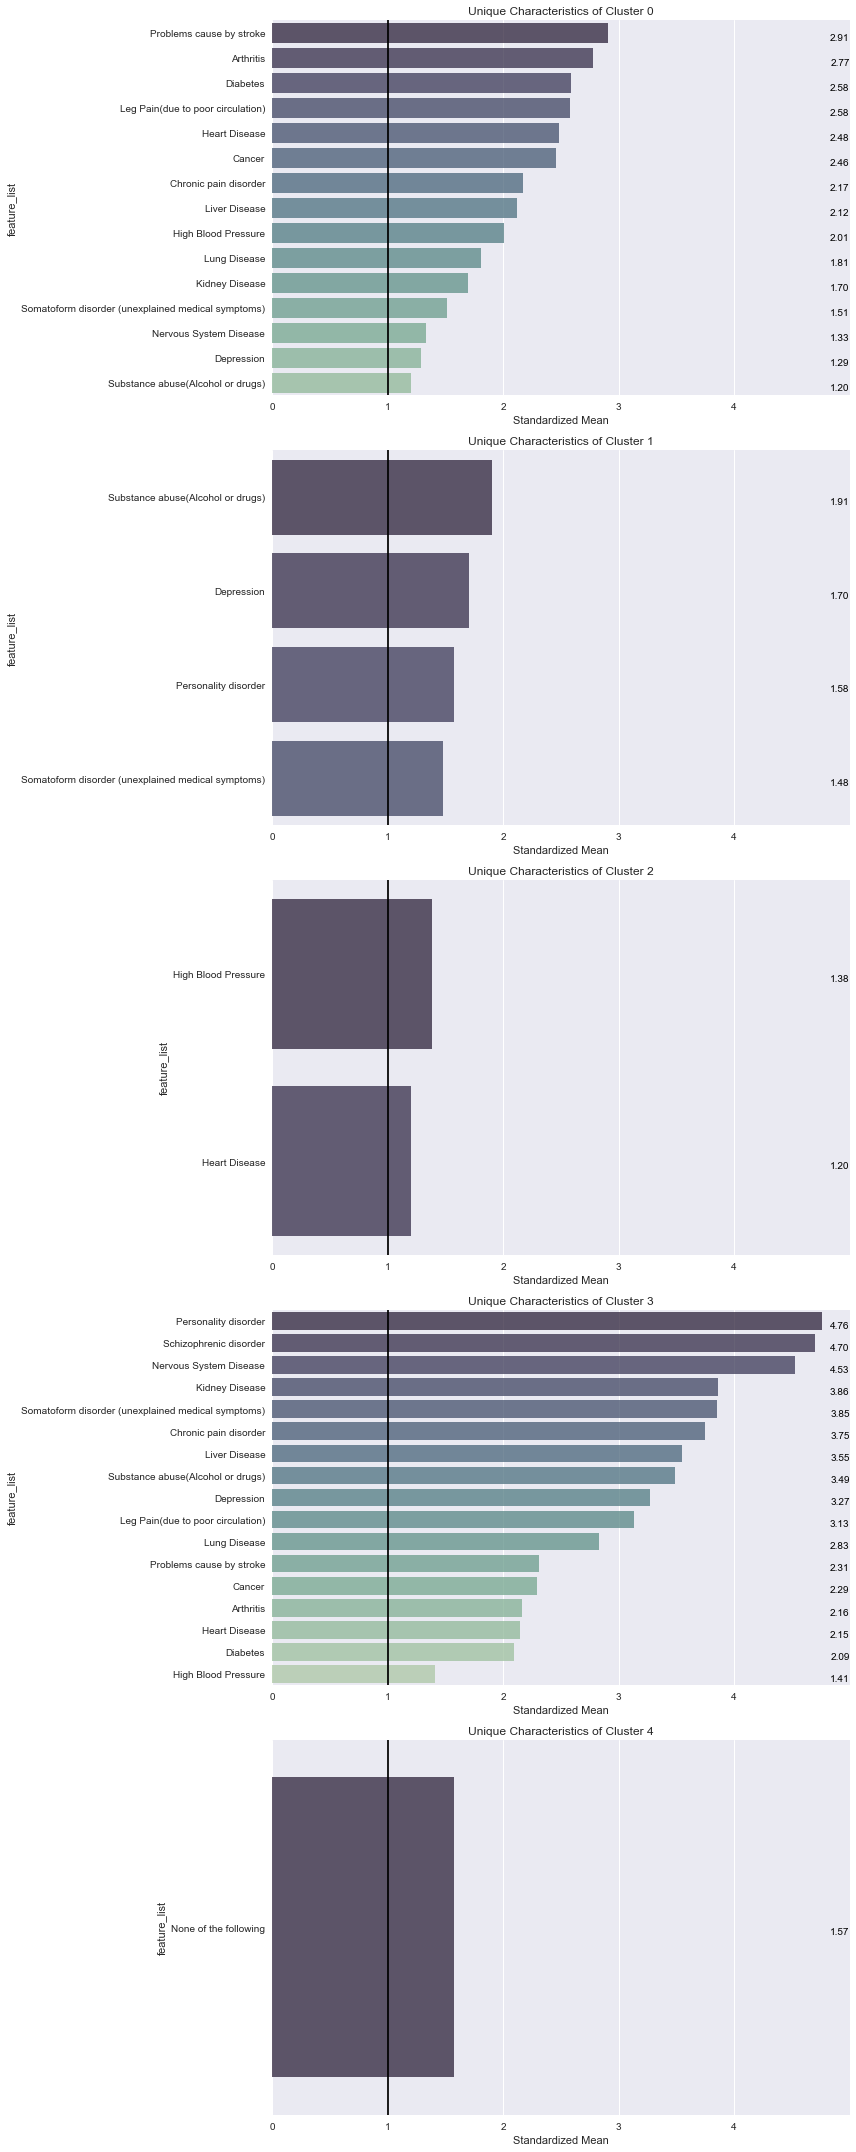

In [170]:
plot_features_all_cluster(df=dfskills, label_col='cluster', n_clusters=5, sensitivity=0.2)

In [28]:
import sys
np.set_printoptions(threshold=sys.maxsize)